## LSTM Practical: Predicting beam profile in synchrotron beam

In this practical we will attempt to build a time series model that can predict the profile of the beam, specifically the RMS of the x-coordinate profile.

This is a multivariate problem, where we have several parameters as inputs. We have the horizontal and vertical control of the injector that control the incoming beam. We also have the time that the acceleration has been running for and finally we have an estimate of the number of the profile.

The aim of this work is to take the results of the low cost simulation and using the LSTM make them match more closely to the high cost accurate simulation - which is your ground truth Y values in this example. To give a sense of the sppedup, the low cost simulations take about 1 second to run, the ground truth simulations take about 16 hours each.

The data for this practical is plotted below. On the left you can see the vertical and horizontal injector control paramaters. On the right you can see the X$_{RMS}$ from the low cost model and those from the full physics simulation.

<img src="https://github.com/stfc-sciml/sciml-workshop/blob/master/course_3.0_with_solutions/markdown_pic/lstm-practical-data.png?raw=1" alt="lstm-practical-data" width="900"/>

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

plt.style.use('ggplot')

## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path + 'sciml-workshop/'
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {bucket_name} 

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

apt -qq update
apt -qq install s3fs fuse
mkdir -p $2
s3fs $3 $2 -o allow_other,use_path_request_style,no_check_certificate,public_bucket=1,ssl_verify_hostname=0,host=https://s3.echo.stfc.ac.uk,url=https://s3.echo.stfc.ac.uk

Running notebook locally.


## The dataset

The data has been preprocessed a bit - so the values are all normalised to between 0 and 1. Use `pandas` to read the csv `<data_path>/lstm-data/injector-data.csv`

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
data = pd.read_csv(data_path + '/lstm-data/injector-data.csv')
```
    
</p>
</details>


In [4]:
data = pd.read_csv(data_path + 'lstm-data/injector-data.csv')

## Our data processing for LSTM function

This is the same fuction that we used in the lecture notebook and will allow us to play with different options for the data. You can copy and paste the function from [lstm_basics.ipynb](lstm_basics.ipynb).

In [5]:
def series_to_tensorflow(data, timesteps=10, n_in=1, n_out=1, feature_indices=None):
    """
    Convert a series to tensorflow input.
    Arguments:
       data: Sequence of observations as a 2D NumPy array of shape (n_times, n_features)
       n_in: Window size of input X
       n_out: Window size of output y
       feature_indices: select features by indices; pass None to use all features
       timesteps: timesteps of LSTM
    Returns:
       X and y for tensorflow.keras.layers.LSTM
    """
    # sizes
    n_total_times, n_total_features = data.shape[0], data.shape[1]
    n_batches = n_total_times - timesteps - (n_in - 1) - (n_out - 1)
    
    # feature selection
    if feature_indices is None:
        feature_indices = list(range(n_total_features))
    
    # data
    X = np.zeros((n_batches, timesteps, n_in, len(feature_indices)), dtype='float32')
    y = np.zeros((n_batches, n_out, len(feature_indices)), dtype='float32')
    for i_batch in range(n_batches):
        for i_in in range(n_in):
            X_start = i_batch + i_in
            X[i_batch, :, i_in, :] = data[X_start:X_start + timesteps, feature_indices]
        y_start = i_batch + timesteps + n_in - 1
        y[i_batch, :, :] = data[y_start:y_start + n_out, feature_indices]
    
    # flatten the last two dimensions
    return X.reshape(n_batches, timesteps, -1), y.reshape(n_batches, -1)

### Refreame the training data

Use the `series_to_tensorflow` function to construct the training data. Here we will set the timesteps to 1000.

We also set a training data limit at 10000.Limiting the data this way results in some over-fitting, but it will allow us to get the model working and training in a reasonable time.

We just use a window of one step backwards and one forwards and we are using featres 1, 2, 3 and 4 in the data as input.

We can use the same function to construct the targets that we are fitting to, in this case we use all of the same settings, but the feature_indices is just feature 5.


In [7]:
# choose timesteps of LSTM
timesteps = 100

# set data limit for training
data_limit_train = 10000

# x using columns 1,2,3,4
x_train, _ = series_to_tensorflow(data.values[:data_limit_train], 
                                  timesteps=timesteps, n_in=1, n_out=1, 
                                  feature_indices=[1, 2, 3, 4])
print(x_train.shape)


# y using column 5
_, y_train = series_to_tensorflow(data.values[:data_limit_train], 
                                  timesteps=timesteps, n_in=1, n_out=1, 
                                  feature_indices=[5])
print(y_train.shape)

(9900, 100, 4)
(9900, 1)


## Build the network

We will build an $LSTM$ using the template of the network from [lstm_basics.ipynb](lstm_basics.ipynb). In the first instance try building a network with one $LSTM$ layer, with 50 units in the layer. The `input_shape` of the network should be `(x_train.shape[1], x_train.shape[2])`.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# Initialising the LSTM
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = False, input_shape=(x_train.shape[1], x_train.shape[2])))

# Adding the output layer
model.add(Dense(units = 1))
```
    
</p>
</details>


In [8]:
# Initialising the LSTM
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = False, input_shape=(x_train.shape[1], x_train.shape[2])))

# Adding the output layer
model.add(Dense(units = y_train.shape[1]))

## Compile and fit the network

Compile the network to use `mae` as the loss and `adam` as the optimiser.

For training initially run for 30 epochs with a batch size of 128 and a validation split of 0.2. Set `shuffle` to `False` for the fitting.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python

model.compile(loss='mae', optimizer='adam')
history = model.fit(x_train, ytrain, epochs=30, 
                    batch_size=128, validation_split=0.2, 
                    shuffle=False)
```
    
</p>
</details>

In [9]:
model.compile(loss='mae', optimizer='adam')
history = model.fit(x_train, y_train, epochs=30, 
                    batch_size=128, validation_split=0.2, 
                    shuffle=False)

Epoch 1/30
62/62 [==============================] - 8s 90ms/step - loss: 0.1868 - val_loss: 0.0829
Epoch 2/30
62/62 [==============================] - 5s 82ms/step - loss: 0.1191 - val_loss: 0.0652
Epoch 3/30
62/62 [==============================] - 6s 92ms/step - loss: 0.0926 - val_loss: 0.0641
Epoch 4/30
62/62 [==============================] - 6s 90ms/step - loss: 0.0841 - val_loss: 0.0624
Epoch 5/30
62/62 [==============================] - 5s 83ms/step - loss: 0.0773 - val_loss: 0.0583
Epoch 6/30
62/62 [==============================] - 5s 80ms/step - loss: 0.0658 - val_loss: 0.0650
Epoch 7/30
62/62 [==============================] - 5s 85ms/step - loss: 0.0678 - val_loss: 0.0597
Epoch 8/30
62/62 [==============================] - 5s 81ms/step - loss: 0.0638 - val_loss: 0.0642
Epoch 9/30
62/62 [==============================] - 5s 78ms/step - loss: 0.0652 - val_loss: 0.0558
Epoch 10/30
62/62 [==============================] - 5s 74ms/step - loss: 0.0608 - val_loss: 0.0579
Epoch 11/

## Take a look at some results

We can look at how the model peroforms on the training set and on an independent test set.

### Training set

First see how we are doing on the training data - if you cannot fit the training data there is no hope on anything else. 

94/94 [==============================] - 1s 12ms/step


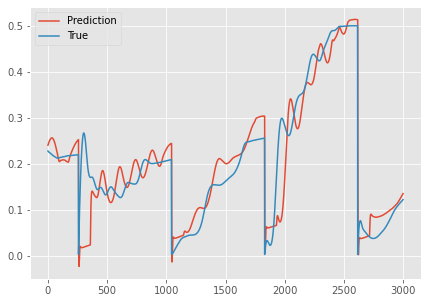

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
preds = model.predict(x_train[2000:5000])
plt.plot(preds[:, 0], label='Prediction')
plt.plot(y_train[2000:5000], label='True')
plt.legend()
plt.show()

### Independent test set

If the model worked okay on the training data a true test is on independent data that was not used for training.

Use `series_to_tensorflow` as above to create the test inputs and outputs.

In [12]:
# set data limit for testing
data_limit_test = 20000

# x using columns 1,2,3,4
x_test, _ = series_to_tensorflow(data.values[data_limit_train:data_limit_test], 
                                  timesteps=timesteps, n_in=1, n_out=1, 
                                  feature_indices=[1, 2, 3, 4])
print(x_test.shape)


# y using column 5
_, y_test = series_to_tensorflow(data.values[data_limit_train:data_limit_test], 
                                  timesteps=timesteps, n_in=1, n_out=1, 
                                  feature_indices=[5])
print(y_test.shape)

(9900, 100, 4)
(9900, 1)


310/310 [==============================] - 4s 13ms/step


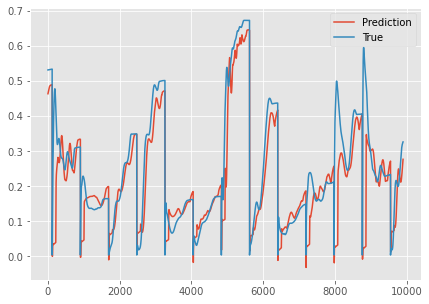

In [13]:
preds = model.predict(x_test)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(preds, label='Prediction')
plt.plot(y_test, label='True')
plt.legend()
plt.show()

## Hyper-parameter tuning

The network is running, but the results could be better. Let's try doing some hyper-parameter tuning. 

Here are some things to try:

* Increase the number of LSTM layers
    - 1, 2, 3 layers of lstm
    - Use just 30 epochs for each of there
    
When you have found the best options - try to increase the training dataset to 400000 and leave the model to train for 1000 epochs. This will probably take quite a long time, so you might want to leave this running overnight.
